# CNN to dog breeds

In this notebook, I aim to apply Tensorflow and Pytorch AI frameworks to classify different Dog breed given an image.

## Data

In [135]:
# Import libraries
# import pandas as pd
import glob
from PIL import Image
from IPython.display import Image as image_i
import os

### Auxiliar functions

In [136]:
# Auxiliar function to drop corrupt images
def check_imgs(path):
    errors = []
    for folder, _, files in os.walk(path):
        for file in files:
            path_tmp = os.path.join(folder, file)
            try:
                with Image.open(path_tmp) as img:
                    img.verify()
            except Exception as e:
                errors.append(path_tmp)
    return errors

In [137]:
def drop_corrupt_imgs(path):
    n = 0
    subfolders = [f.path for f in os.scandir(path) if f.is_dir()]
    for subfolder in subfolders:
        path_tmp = os.path.join(path, subfolder)
        corrupt_imgs = check_imgs(path_tmp)
        for ruta in corrupt_imgs:
            os.remove(ruta)
            n+=1
    print(f"We have removed {n} corrupt images.")

### Load data

In [138]:
# Load the dog images (.jpg extension)
dog_images = glob.glob("dogimages/**/*.jpg", recursive=True)
num_dog_images = len(dog_images)
print(f"There are {num_dog_images} dog images.")

There are 8351 dog images.


In [139]:
# Train
train_dog_images = glob.glob("dogimages/train/**/*.jpg", recursive=True)
num_train_dog_images = len(train_dog_images)
print(f"There are {num_train_dog_images} dog images for train.")

There are 6680 dog images for train.


In [140]:
# Validation
val_dog_images = glob.glob("dogimages/valid/**/*.jpg", recursive=True)
num_val_dog_images = len(val_dog_images)
print(f"There are {num_val_dog_images} dog images for validation.")

There are 835 dog images for validation.


In [141]:
# Test
test_dog_images = glob.glob("dogimages/test/**/*.jpg", recursive=True)
num_test_dog_images = len(test_dog_images)
print(f"There are {num_test_dog_images} dog images for test.")

There are 836 dog images for test.


In [142]:
# We check that there is no any wrong or missing image
assert num_dog_images == num_train_dog_images + num_val_dog_images + num_test_dog_images

In [143]:
# We check corrupt images
path = os.path.join(os.getcwd(), "dogimages")
train_path = os.path.join(path, "train")
valid_path = os.path.join(path, "valid")
test_path = os.path.join(path, "test")
print(f"Cheking train in {train_path}...")
drop_corrupt_imgs(train_path)
print(f"Cheking valid in {valid_path}...")
drop_corrupt_imgs(valid_path)
print(f"Cheking test in {test_path}...")
drop_corrupt_imgs(test_path)

Cheking train in c:\Users\alvar\Desktop\Portfolio\CNN-dog-breed\dogimages\train...
We have removed 0 corrupt images.
Cheking valid in c:\Users\alvar\Desktop\Portfolio\CNN-dog-breed\dogimages\valid...
We have removed 0 corrupt images.
Cheking test in c:\Users\alvar\Desktop\Portfolio\CNN-dog-breed\dogimages\test...
We have removed 0 corrupt images.


In [144]:
# Different breeds
dog_breeds = glob.glob("dogimages/train/*")
dog_breeds = [dog_breed_tmp.split(".")[1] for dog_breed_tmp in dog_breeds]

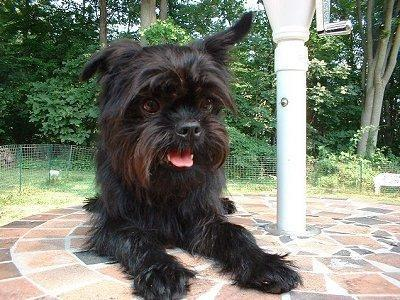

In [145]:
# Show an image
image_i(train_dog_images[0])

**TODO**: Show some image

## CNN

In [146]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

### Tensorflow

In [147]:
# Import libraries
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

**Step 1**: Load data

In [148]:
# Image size redimension
IMG_SIZE = (224, 224)
# Images per Batch (bigger = more RAM)
BATCH_SIZE = 20
# Carga las imágenes desde la carpeta "data/train"
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dogimages/train",      # Path
    image_size=IMG_SIZE,    # Image redimension -> 128x128
    batch_size=BATCH_SIZE,  # Groups (batchs) of 32 images
    shuffle=True            # To improve the training process
)

# Same for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    "dogimages/valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


# Same for test
test_ds = tf.keras.utils.image_dataset_from_directory(
    "dogimages/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# We automatically obtain the classes
class_names = train_ds.class_names
print("Clases encontradas:", class_names)

Found 6680 files belonging to 133 classes.
Found 835 files belonging to 133 classes.
Found 836 files belonging to 133 classes.
Clases encontradas: ['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Bru

**Step 2**: Normalizar imágenes y preparar el pipeline de datos

In [149]:
# TensorFlow can automatically optimize the number of threads when loading data
AUTOTUNE = tf.data.AUTOTUNE

# Pixels from inter [0,255] to float [0.0,1.0]
def preprocess(ds):
    return ds.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),  # Image normalizarion
        num_parallel_calls=AUTOTUNE
    )

# Train
train_ds = (
    preprocess(train_ds)             # Image normalization
    .cache()                         # Save data after first usage
    .shuffle(1000)                   # Shuffle to improve the training process
    .prefetch(buffer_size=AUTOTUNE)  # Preparing next batch whereas this is training (remember: parallel mode is active)
)

# Validation
val_ds = (
    preprocess(val_ds)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# Test
test_ds = (
    preprocess(test_ds)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [150]:
# fourth model architecture (add batch normalization)
model = Sequential([
    Input(shape=(*IMG_SIZE, 3)),
    # 1st 2D-Convolution Layer
    Conv2D(16, (3, 3), padding='same', use_bias=False),	
    # 1st Batch Normalization Layer
    BatchNormalization(axis=3, scale=False),	
    # 1st Activation Layer
    Activation('relu'),
    # 1st Max-Pooling Layer
    MaxPooling2D((4, 4), strides=(4, 4), padding='same'),
    # 1st Dropout Layer
    Dropout(0.2),
    # 2nd 2D-Convolution Layer
    Conv2D(32, (3, 3), padding='same', use_bias=False),
    # 2nd Batch Normalization Layer
    BatchNormalization(axis=3, scale=False),	
    # 2nd Activation Layer
    Activation('relu'),
    # 2nd Max-Pooling Layer
    MaxPooling2D((4, 4), strides=(4, 4), padding='same'),
    # 2nd Dropout Layer
    Dropout(0.2),
    # 3rd 2D-Convolution Layer
    Conv2D(64, (3, 3), padding='same', use_bias=False),
    # 3rd Batch Normalization Layer
    BatchNormalization(axis=3, scale=False),
    # 3rd Activation Layer
    Activation('relu'),
    # 3rd Max-Pooling Layer
    MaxPooling2D((4, 4), strides=(4, 4), padding='same'),
    # 3rd Dropout Layer
    Dropout(0.2),
    # 4th Convolution Layer
    Conv2D(128, (3, 3), padding='same', use_bias=False),
    # 4th Batch Normalization Layer
    BatchNormalization(axis=3, scale=False),
    # 4th Activation Layer
    Activation('relu'),
    # 1st Flatten Layer
    Flatten(),
    # 4th Dropout Layer
    Dropout(0.2),
    # 1st Dense Layer
    Dense(512, activation='relu'),
    # Fully-Connected Layer
    Dense(len(class_names), activation='softmax'),
])
    
    

In [151]:
# Compiling the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model.summary()

**Step 4**: Train the model

In [153]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.0126 - loss: 5.0024

c:\Users\alvar\miniconda3\envs\dog-env\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


334/334 ━━━━━━━━━━━━━━━━━━━━ 80s 238ms/step - accuracy: 0.0127 - loss: 5.0018 - val_accuracy: 0.0096 - val_loss: 5.1555
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 78s 234ms/step - accuracy: 0.0365 - loss: 4.4360 - val_accuracy: 0.0180 - val_loss: 5.1028
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 73s 220ms/step - accuracy: 0.0498 - loss: 4.2397 - val_accuracy: 0.0299 - val_loss: 4.7833
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 76s 226ms/step - accuracy: 0.0679 - loss: 4.0809 - val_accuracy: 0.0347 - val_loss: 4.6180
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 77s 229ms/step - accuracy: 0.0860 - loss: 3.9370 - val_accuracy: 0.0635 - val_loss: 4.1221
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 78s 233ms/step - accuracy: 0.0949 - loss: 3.8160 - val_accuracy: 0.0311 - val_loss: 4.8821
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 75s 224ms/step - accuracy: 0.1162 - loss: 3.7404 - val_accuracy: 0.0671 - val_loss: 4.1559
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 74s 220ms/step - accuracy: 0.1265 - loss: 3.6026 - val

**Step 5**: Test the model

In [154]:
# Test the test data (without being used until now)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0907 - loss: 4.0878
Test Accuracy: 8.37%


### Pytorch